# Workbench Setup

## Google Colab Installation

In [1]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Code specific to Google Colab
    print("Running in Google Colab")

    # Additional setup commands for Colab
    !pip install neuralforecast
    !pip install gymnasium
    !pip install QuantStats
else:
    # Code for other environments (e.g., VS Code)
    print("Running in another environment (e.g., VS Code)")

Running in another environment (e.g., VS Code)


In [2]:
if IN_COLAB:
    # Retrive required files
    !wget --recursive --no-parent --cut-dirs=4 -P /content https://raw.githubusercontent.com//CodeBeckZero/MADDQN/main/environments/stockenv.py
    !wget --recursive --no-parent --cut-dirs=4 -P /content https://raw.githubusercontent.com//CodeBeckZero/MADDQN/main/utilities/cleandata.py
    !wget --recursive --no-parent --cut-dirs=4 -P /content https://raw.githubusercontent.com//CodeBeckZero/MADDQN/main/utilities/data.py
    !wget --recursive --no-parent --cut-dirs=4 -P /content https://raw.githubusercontent.com//CodeBeckZero/MADDQN/main/utilities/epsilon_decay.py
    !wget --recursive --no-parent --cut-dirs=4 -P /content https://raw.githubusercontent.com//CodeBeckZero/MADDQN/main/utilities/agentperform.py
    !wget --recursive --no-parent --cut-dirs=4 -P /content https://raw.githubusercontent.com//CodeBeckZero/MADDQN/main/agent/ddqn.py
    !wget --recursive --no-parent --cut-dirs=4 -P /content https://raw.githubusercontent.com//CodeBeckZero/MADDQN/main/agent/random.py
    !wget --recursive --no-parent --cut-dirs=4 -P /content https://raw.githubusercontent.com//CodeBeckZero/MADDQN/main/reward/stockmarket.py            
    # Move all directories and files from content/raw.githubusercontent.com to content/
    !mv /content/raw.githubusercontent.com/* /content/

    # Delete the raw.githubusercontent.com directory
    !rm -rf /content/raw.githubusercontent.com

## Software Enviornment Setup

In [3]:
import os
import sys
import torch
import optuna
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import utilities.agentperform as agentperform
import utilities.cleandata as cln 
from utilities.epsilon_decay import linear_decay
from utilities.data import UniStockEnvDataStruct, TimesNetProcessing
from agents.ddqn import DdqnAgent
from rewards.stockmarket import future_profit, risk_reward
from environments.stockenv import ContinuousOHLCVEnv
from datetime import datetime
from neuralforecast.core import NeuralForecast
from neuralforecast.models import TimesNet
from neuralforecast.losses.numpy import mae, mse
import logging
# 
logging.getLogger("pytorch_lightning.utilities.rank_zero").addHandler(logging.NullHandler())
logging.getLogger("pytorch_lightning.accelerators.cuda").addHandler(logging.NullHandler())
os.environ['NIXTLA_ID_AS_COL'] = '1' # Prevent Warning 

def set_seed(seed):
    """Set seed for reproducibility."""
    # Python random module
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)

    # If you are using CUDA
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        # Additional settings to force determinism in your operations:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False



# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # Get the current device
    device = torch.cuda.current_device()
    print(f"GPU Name: {torch.cuda.get_device_name(device)}")
else:
    device = 'cpu'
    print("CUDA (GPU support) is not available. PyTorch is running on CPU.")


def decimal_to_text(decimal_number):
    # Remove the decimal point and convert to integer
    integer_part = int(decimal_number * 1000)
    # Convert the integer to text
    text_representation = str(integer_part)
    return text_representation

CUDA (GPU support) is not available. PyTorch is running on CPU.


## RL Environment Setup

In [4]:
RANDOM_SEED = 42
set_seed(RANDOM_SEED)

if not IN_COLAB:
    pwd = "C:/programming/MADDQN"
    sys.path.append(pwd)
    
    # Output Path Location for CSV export
    export_path = pwd + "/output_data"

# Input Data Location, File Name, Stock name for labels
input_url = 'https://raw.githubusercontent.com/CodeBeckZero/MADDQN/main/input_data'

stock_inputs ={'DJI':'^DJI_daily.csv',
               'NDAQ': '^IXIC_daily.csv',
               'SP500': '^SPX_daily.csv',
               'AAPL': 'AAPL_daily.csv',
               'AMZN': 'AMZN_daily.csv',
               'GOOGL': 'GOOGL_daily.csv',
               'MSFT': 'MSFT_daily.csv',
               'SINE': 'sine_wave_daily.csv',
               'FORD': 'F_daily.csv',
               'JNJ': 'JNJ_daily.csv',
               'NEE': 'NEE_daily.csv',
               'PFE': 'PFE_daily.csv',
               'TSLA': 'TSLA_daily.csv',
               'COKE': 'COKE_daily.csv',
               'PG': 'PG_daily.csv'}

# Training Inputs
trn_keys = ['DJI','NDAQ','SP500']
training_range = ('2007-01-01','2008-12-31')
trn_dt_range = [datetime.strptime(dt_str, "%Y-%m-%d") for dt_str in training_range]

# Validation Inputs
val_keys = trn_keys
validation_range = ('2009-01-01', '2009-12-31')
val_dt_range = [datetime.strptime(dt_str, "%Y-%m-%d") for dt_str in validation_range]

# Testing Inputs
tst_keys = trn_keys#['AAPL','AMAZON','GOOGL','MSFT','FORD','JNJ','NEE','PFE','TSLA','COKE','PG']
testing_range = ('2010-01-01', '2010-12-31')
tst_dt_range = [datetime.strptime(dt_str, "%Y-%m-%d") for dt_str in testing_range]

window_size = 28 # Needs to match the size Timesnet is trained on
price_based_on = 'close'
columns = ['open','high','low','close','volume']

## RL Enviornment Generation

In [5]:
env_data = {}
env = {}

for stock, file in stock_inputs.items():
    if stock in set(trn_keys + val_keys + tst_keys):
        # Import
        df = cln.YAHOO_csv_input(file, input_url)
        data_dic = UniStockEnvDataStruct(df,price_based_on,window_size)
        env_data[stock] = data_dic
        env[stock] = ContinuousOHLCVEnv(name=stock,
                                        ohlcv_data = env_data[stock]['rw_raw_env'] ,
                                        stock_price_data= env_data[stock]['rw_raw_price_env'],
                                        commission_rate=0.005)

c:\Users\beckm\anaconda3\envs\MADDQN\Lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
c:\Users\beckm\anaconda3\envs\MADDQN\Lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
c:\Users\beckm\anaconda3\envs\MADDQN\Lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [6]:
trn_idx = {}
val_idx = {}
tst_idx = {}

for stock, file in stock_inputs.items():
    if stock in set(trn_keys + val_keys + tst_keys):
        if stock in trn_keys:
            trn_idx[stock] = env_data[stock].gen_rw_idxs(trn_dt_range)
        if stock in val_keys:
            val_idx[stock] = env_data[stock].gen_rw_idxs(val_dt_range)
        if stock in tst_keys:
            tst_idx[stock] = env_data[stock].gen_rw_idxs(tst_dt_range)


# Agent Setup

## Preprocessing

### TimesNet

In [7]:
train_tn_model = False
import_tn_model = False
import_tn_csvs = True
tn_path = pwd + '/gen_data/timesnet/'

#### Train

In [8]:
n_prediction = 5

if train_tn_model:
    
    model = TimesNet(h = n_prediction, # Forecast horizon
                    input_size = window_size, # Length of Batches
                    batch_size = 1, # Number of timeseries to predict
                    #futr_exog_list = remaining_columns,
                    hidden_size = 128, # Size of embedding for embedding and encoders,
                    dropout = 0.40, # Dropout for embeddings
                    conv_hidden_size = 3, # Channels for the inception block
                    top_k = 5, # Top num of periods from FFT considered
                    num_kernels = 13, # number of kernels for the inception block
                    encoder_layers = 3, # num of encoders
                    max_steps = 1000, # of training steps
                    early_stop_patience_steps = 10, #early stoppage on validation
                    val_check_steps = 100, # Val check every X steps,
                    windows_batch_size = 150, # Number of windows in training epoch,
                    num_workers_loader = 7,
                    learning_rate = 0.0003,
                    random_seed = RANDOM_SEED)

In [9]:
if train_tn_model:
  nf = NeuralForecast(models=[model], freq='d')
  results = {}
  for key in trn_keys:
    results[key] = nf.fit(df=env[key],val_size=0.2)

  nf.save(path= tn_path,
          model_index=None,
          overwrite=True,
          save_dataset=True)

#### Import Model

In [10]:
if import_tn_model:
# Define the correct path
  if IN_COLAB:
    
    model_path = os.path.join(os.getcwd(), 'gen_data', 'timesnet')

    # Ensure the directory and file exist
    if os.path.exists(model_path):
        nf = NeuralForecast.load(path=model_path)
    else:
        raise FileNotFoundError(f"Model path {model_path} does not exist.")

#### Import Timesnet CSVs

In [11]:
if import_tn_csvs:

    if IN_COLAB:
        # Input Data Location, File Name, Stock name for labels
        csv_path = 'https://raw.githubusercontent.com/CodeBeckZero/MADDQN/main/gen_data/csvs/'

    else:
        csv_path  = pwd +'/gen_data/csvs/'

    stock_tn ={'DJI':'DJI_tn.csv',
                'NDAQ': 'NDAQ_tn.csv',
                'SP500': 'SP500_tn.csv',
                'AAPL': 'AAPL_tn.csv',
                'AMZN': 'AMZN_tn.csv',
                'GOOGL': 'GOOGL_tn.csv',
                'MSFT': 'MSFT_tn.csv',
                'FORD': 'FORD_tn.csv',
                'JNJ': 'JNJ_tn.csv',
                'NEE': 'NEE_tn.csv',
                'PFE': 'PFE_tn.csv',
                'TSLA': 'TSLA_tn.csv',
                'COKE': 'COKE_tn.csv',
                'PG': 'PG_tn.csv'}

    timesnet = TimesNetProcessing(env_data)

## DDQN Setup

In [12]:
env_mod_func = {'train': timesnet.process,
               'import':timesnet.process,
               'csv':timesnet.csv_process,}

best_ddqn_agent = DdqnAgent(name='profit',
                        environment=None,
                        reward_function = future_profit,
                        reward_params = {'n':5},
                        env_state_mod_func = env_mod_func['csv'],     
                        input_size= 11,
                        hidden_size= 256, 
                        output_size=3, 
                        activation_function = nn.Tanh(),
                        num_hidden_layers = 2,                  
                        buffer_size= 150, 
                        batch_size = 30,
                        alpha = 0.01,
                        gamma = 0.97,
                        opt_wgt_dcy = 0,
                        dropout_rate = 0.25,                
                        device = device)

## Train DDQN

In [13]:
def metric_function(env):
    metric = env.step_info[-1]['New Portfolio Value'] -  env.step_info[-1]['Portfolio Value']
    return metric

In [14]:
for key, rl_env in env.items():
    
    if key in trn_keys:
        timesnet.upload_csv(csv_path + stock_tn[key])
        print(env[key].agent_sequence,env[key].DECISION_AGENT,env[key].agents)
        env[key].add_agent(best_ddqn_agent.get_name())
        env[key].set_decision_agent(best_ddqn_agent.get_name())
        best_ddqn_agent.set_environment(rl_env)
        best_ddqn_agent.train(start_idx = trn_idx[key][0],
                    end_idx=trn_idx[key][1],
                    training_episodes= 50,
                    epsilon_decya_func= linear_decay,
                    initial_epsilon= 0.9,
                    final_epsilon= 0.1,
                    update_q_freq= 1,
                    update_tgt_freq= 10,
                    save_path = export_path,
                    val_start_idx = val_idx[key][0],
                    val_end_idx = val_idx[key][1],
                    metric_func= metric_function,
                    min_training_episodes = 10, 
                    early_stop = True,
                    stop_metric = 'val_tot_r',
                    stop_patience = 5,
                    stop_delta = 0.001)
    
        ## Export Training Session Data to CSV
        ddqn_trn = best_ddqn_agent.get_training_episodic_data()
        ddqn_trn.to_csv('test.csv')
        display(ddqn_trn)
        env[key].remove_agent(best_ddqn_agent.get_name())

[] None set()
DJI ENV: Agent profit added
DJI ENV: Agent profit assigned as decision agent
profit: Training Initialized on DJI[0:476] -> Validation on DJI[504:728]
profit: EP 26 of 50 Finished -> ΔQ1 = 0.75, ΔQ2 = 0.51 | ∑R = 24.90, μR = 0.05 σR = 2.16 | Max: val_tot_r = 7819.99 -> EarlyStopping counter: 5 out of 5                                                                                                  
profit: Early Stoppage on EP 26 -> Best QNet Loaded from EP 21

profit: Training finished on DJI[0:476]


,trn_ep,tot_r,avg_r,std_r,Q1_loss,Q2_loss,epsilon,val_tot_r,val_avg_r,val_std_r,val_ror,val_comm_cost
0,1,-65.428325,-0.137454,2.499417,0.936878,0.340275,0.900,21854.12755,97.563069,889.409874,1.218541,3390.26245
1,2,-98.748109,-0.207454,2.374881,0.641423,0.668071,0.884,49485.03000,220.915313,1454.367288,1.501800,1223.25000
2,3,-86.369102,-0.181448,2.482691,0.694825,0.519981,0.867,-43323.22765,-193.407266,866.227099,0.569250,55849.61765
3,4,-74.614872,-0.156754,2.634357,0.529894,0.446444,0.851,16810.55660,75.047128,1013.032567,1.173566,48053.60340
4,5,0.599518,0.001259,2.452239,0.608073,0.695058,0.835,0.00000,0.000000,0.000000,1.000000,0.00000
5,6,-42.313917,-0.088895,2.504277,0.860497,0.832784,0.818,-3756.06245,-16.768136,123.543481,0.962439,5681.63245
6,7,-62.713948,-0.131752,1.819519,0.498685,0.352897,0.802,-44069.52775,-196.738963,721.166847,0.559305,66056.47775
7,8,-93.165933,-0.195727,2.284745,1.327209,0.510905,0.786,-25387.69010,-113.337902,1033.774267,0.749598,63052.05010
8,9,-15.169219,-0.031868,2.132862,0.634196,0.622716,0.769,-26246.02610,-117.169759,967.334698,0.737540,80294.76610
9,10,17.973177,0.037759,2.197722,0.689690,0.608971,0.753,-15691.23945,-70.050176,829.476163,0.847059,58805.12945


DJI ENV: Agent profit removed
[] None set()
NDAQ ENV: Agent profit added
NDAQ ENV: Agent profit assigned as decision agent
profit: Training Initialized on NDAQ[0:476] -> Validation on NDAQ[504:728]
profit: EP 17 of 50 Finished -> ΔQ1 = 0.66, ΔQ2 = 0.73 | ∑R = -73.62, μR = -0.15 σR = 2.38 | Max: val_tot_r = -54686.89 -> EarlyStopping counter: 5 out of 5                                                                                              
profit: Early Stoppage on EP 17 -> Best QNet Loaded from EP 12

profit: Training finished on NDAQ[0:476]


,trn_ep,tot_r,avg_r,std_r,Q1_loss,Q2_loss,epsilon,val_tot_r,val_avg_r,val_std_r,val_ror,val_comm_cost
0,1,-131.926347,-0.277156,2.780610,0.841826,0.953214,0.900,28840.75320,128.753363,917.618985,1.293210,1133.24680
1,2,-1.556648,-0.003270,2.864584,0.877736,0.432607,0.884,0.00000,0.000000,0.000000,1.000000,0.00000
2,3,-34.933185,-0.073389,2.839139,1.016393,1.284237,0.867,-54414.02130,-242.919738,1000.243607,0.457575,76338.28130
3,4,-68.132955,-0.143136,2.779556,1.049063,0.841340,0.851,2435.65815,10.873474,569.310775,1.024357,29762.23185
4,5,-59.666894,-0.125351,2.359557,0.819703,0.828912,0.835,37847.37280,168.961486,1826.583967,1.383620,23258.68720
5,6,-128.922696,-0.270846,2.880280,1.531006,1.509008,0.818,62506.83215,279.048358,1815.824462,1.631158,6974.01785
6,7,-2.089319,-0.004389,2.759578,0.506141,0.728728,0.802,61367.43795,273.961777,1749.802330,1.619764,2564.71205
7,8,-33.778773,-0.070964,2.487114,1.087190,1.096064,0.786,-51423.29340,-229.568274,1041.280330,0.485767,74517.95340
8,9,-45.926093,-0.096483,2.561845,1.073731,1.167108,0.769,0.00000,0.000000,0.000000,1.000000,0.00000
9,10,20.664584,0.043413,2.448542,0.397339,0.763238,0.753,67974.29345,303.456667,1886.368355,1.679743,4323.11655


NDAQ ENV: Agent profit removed
[] None set()
SP500 ENV: Agent profit added
SP500 ENV: Agent profit assigned as decision agent
profit: Training Initialized on SP500[0:476] -> Validation on SP500[504:728]
profit: EP 21 of 50 Finished -> ΔQ1 = 0.99, ΔQ2 = 1.00 | ∑R = -61.78, μR = -0.13 σR = 2.66 | Max: val_tot_r = 838.26 -> EarlyStopping counter: 5 out of 5                                                                                                 
profit: Early Stoppage on EP 21 -> Best QNet Loaded from EP 16

profit: Training finished on SP500[0:476]


,trn_ep,tot_r,avg_r,std_r,Q1_loss,Q2_loss,epsilon,val_tot_r,val_avg_r,val_std_r,val_ror,val_comm_cost
0,1,-21.628275,-0.045438,2.280614,0.756427,0.681862,0.900,-26188.78615,-116.914224,869.388725,0.738112,64867.35615
1,2,-59.678267,-0.125375,2.010810,0.635001,1.014920,0.884,28775.76920,128.463255,1323.708044,1.293982,16777.15080
2,3,-103.527502,-0.217495,2.431914,0.751570,0.683216,0.867,13787.97725,61.553470,692.654746,1.137880,14356.23275
3,4,-31.920387,-0.067060,2.394047,0.780886,0.798913,0.851,30858.10600,137.759402,839.772845,1.308581,11379.31400
4,5,-12.529946,-0.026323,2.281963,0.692365,0.461301,0.835,25026.58710,111.725835,1346.670474,1.256327,16980.25290
5,6,-30.833799,-0.064777,2.376570,1.001540,0.972002,0.818,41286.67830,184.315528,1719.706491,1.419686,1206.82170
6,7,-85.930244,-0.180526,2.336732,0.738392,0.630067,0.802,56802.64645,253.583243,1554.913645,1.575603,7151.08355
7,8,-45.505604,-0.095600,2.345712,0.636578,0.678933,0.786,-30301.90130,-135.276345,1279.320347,0.700336,65831.70130
8,9,-39.191387,-0.082335,2.627657,0.697109,0.753277,0.769,-28093.50045,-125.417413,1131.592012,0.722529,82155.55045
9,10,-52.717808,-0.110752,2.648935,0.854929,0.389691,0.753,-10129.55500,-45.221228,740.745468,0.898704,45279.91500


SP500 ENV: Agent profit removed


## Testing DDQN Agent

DJI ENV: Agent profit already exists
DJI ENV: Agent profit assigned as decision agent
Seq: ['profit'], DA: profit, Agents: {'profit'}
profit: Testing Initialized on DJI[756:980]
profit - DJI[756:980] - Testing Finished - EP - 1 of 1-> ∑R = 26457.78, μR = 118.12σR = 847.96
profit: Testing Complete on DJI[756:980]
[10144.19 10099.14 10268.81 10309.24 10392.9  10402.35 10383.38 10282.41
 10374.16 10321.03 10325.26 10403.79 10405.98 10396.76 10444.14 10566.2
 10552.52 10564.38 10567.33 10611.84 10624.69 10642.15 10685.98 10733.67
 10779.17 10741.98 10785.89 10888.83 10836.15 10841.21 10850.36 10895.86
 10907.42 10856.63 10927.07 10973.55 10969.99 10897.52 10927.07 10997.35
 11005.97 11019.42 11123.11 11144.57 11018.66 11092.05 11117.06 11124.92
 11134.29 11204.28 11205.03 10991.99 11045.27 11167.32 11008.61 11151.83
 10926.77 10866.83 10520.32 10380.43 10785.14 10748.26 10896.91 10782.95
 10620.16 10625.83 10510.95 10444.37 10068.01 10193.39 10066.57 10043.75
  9974.45 10258.99 10136.63 10

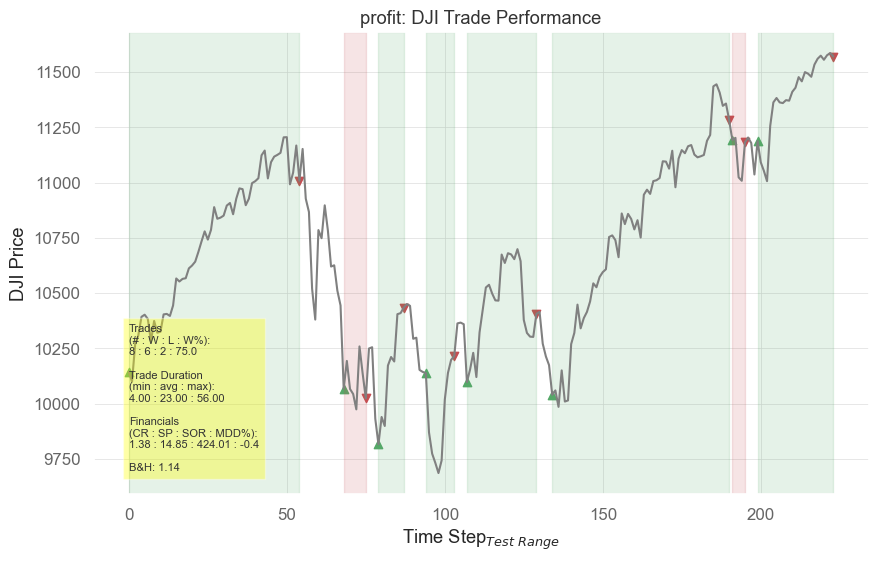

DJI ENV: Agent profit removed
NDAQ ENV: Agent profit added
NDAQ ENV: Agent profit assigned as decision agent
Seq: ['profit'], DA: profit, Agents: {'profit'}
profit: Testing Initialized on NDAQ[756:980]
profit - NDAQ[756:980] - Testing Finished - EP - 1 of 1-> ∑R = 26115.01, μR = 116.58σR = 1128.64
profit: Testing Complete on NDAQ[756:980]
[2177.41 2183.53 2214.19 2226.29 2241.71 2243.87 2242.03 2213.44 2235.9
 2234.22 2238.26 2273.57 2280.79 2280.68 2292.31 2326.35 2332.21 2340.68
 2358.95 2368.46 2367.66 2362.21 2378.01 2389.09 2391.28 2374.41 2395.4
 2415.24 2398.76 2397.41 2395.13 2404.36 2410.69 2397.96 2402.58 2429.53
 2436.81 2431.16 2436.81 2454.05 2457.87 2465.99 2504.86 2515.69 2481.26
 2480.11 2500.31 2504.61 2519.07 2530.15 2522.95 2471.47 2471.73 2511.92
 2461.19 2498.74 2424.25 2402.29 2319.64 2265.64 2374.67 2375.31 2425.02
 2394.36 2346.85 2354.23 2317.26 2298.37 2204.01 2229.04 2213.55 2210.95
 2195.88 2277.68 2257.04 2222.33 2281.07 2303.03 2219.17 2173.9  2170.57
 215

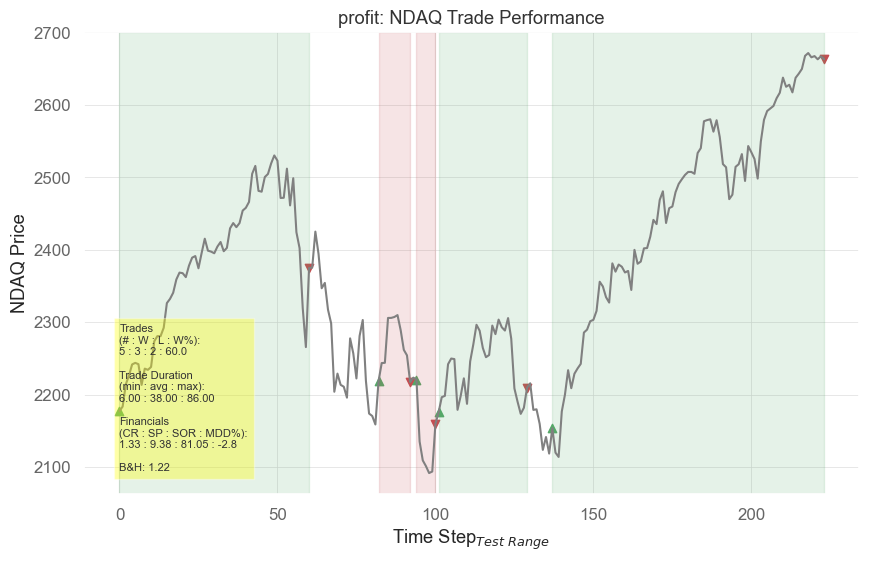

NDAQ ENV: Agent profit removed
SP500 ENV: Agent profit added
SP500 ENV: Agent profit assigned as decision agent
Seq: ['profit'], DA: profit, Agents: {'profit'}
profit: Testing Initialized on SP500[756:980]
profit - SP500[756:980] - Testing Finished - EP - 1 of 1-> ∑R = 37189.96, μR = 166.03σR = 1005.79
profit: Testing Complete on SP500[756:980]
[1078.47 1075.51 1094.87 1099.51 1106.75 1109.17 1108.01 1094.6  1105.24
 1102.94 1104.49 1115.71 1118.31 1118.79 1122.97 1138.7  1138.5  1140.45
 1145.61 1150.24 1149.99 1150.51 1159.46 1166.21 1165.83 1159.9  1165.81
 1174.17 1167.72 1165.73 1166.59 1173.22 1173.27 1169.43 1178.1  1187.44
 1189.44 1182.45 1186.44 1194.37 1196.48 1197.3  1210.65 1211.67 1192.13
 1197.52 1207.17 1205.94 1208.67 1217.28 1212.05 1183.71 1191.36 1206.78
 1186.69 1202.26 1173.6  1165.87 1128.15 1110.88 1159.73 1155.79 1171.67
 1157.44 1135.68 1136.94 1120.8  1115.05 1071.59 1087.69 1073.65 1074.03
 1067.95 1103.06 1089.41 1070.71 1098.38 1102.83 1064.88 1050.47 1062

c:\Users\beckm\anaconda3\envs\MADDQN\Lib\site-packages\quantstats\stats.py:349: RuntimeWarning: divide by zero encountered in scalar divide
  res = returns.mean() / downside


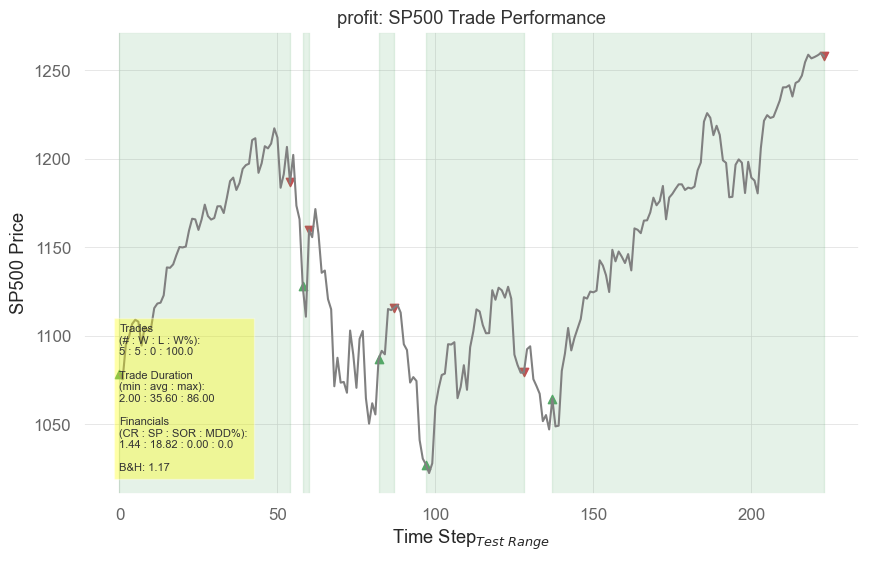

SP500 ENV: Agent profit removed


In [25]:
for key, rl_env in env.items():   
    test_name_path = f'{export_path}/{best_ddqn_agent.get_name()}'       
    if key in tst_keys:
        
        test_name = f'{best_ddqn_agent.get_name()}-TST-{key}-{tst_idx[key][0]}_{tst_idx[key][0]}'
        timesnet.upload_csv(csv_path + stock_tn[key])
        env[key].add_agent(best_ddqn_agent.get_name())
        env[key].set_decision_agent(best_ddqn_agent.get_name())
        print(f'Seq: {env[key].agent_sequence}, DA: {env[key].DECISION_AGENT}, Agents: {env[key].agents}')
        best_ddqn_agent.set_environment(rl_env)
        best_ddqn_agent.test(start_idx = tst_idx[key][0],
                             end_idx = tst_idx[key][1],
                             metric_func= metric_function,
                             testing_episodes=1)
    
    
        ## Export Test data
        a = env[key].get_step_data()
        b = best_ddqn_agent.get_step_data()
        combined_df = pd.concat([a,b],axis=1)
        tst_df_file_name  = f'{test_name}.csv'
        trn_df_save_path = test_name_path + '/' + tst_df_file_name
        combined_df.to_csv(trn_df_save_path)

        ## Generate Trading Graphic
        tst_graph_file_name = trn_df_save_path[:-4] + '.png'
        agentperform.agent_stock_performance(env[key].stock_price_data[tst_idx[key][0]:tst_idx[key][1]][:,-1,0], # Selecting all batches, last price of window, closing price
                                            combined_df['Env Action'].to_numpy(),
                                            key,
                                            best_ddqn_agent.get_name(),
                                            display_graph=True,
                                            save_graphic=True,
                                            path_file=tst_graph_file_name)
        env[key].remove_agent(best_ddqn_agent.get_name())
        

## Hypertuning

In [ ]:
"""
# For Objective function, need to create agent name before to link agent with enviornment
agent_name = 'REWARD_DDQN_AGENT'
agent_path = export_path + '/' + agent_name
metric = 'val_ror'

for key, env in environments.items():
  
        env.add_agent(agent_name)
        env.set_decision_agent(agent_name)

def objective(trial):
    
    # Define the hyperparameters to search over
    
    ## NN hyperparameters
    sug_hidden_layers = trial.suggest_int('hidden_layers', low=1, high=3)
    sug_hidden_size = trial.suggest_int('hidden_size', low=256, high=1280, step=64)
    sug_update_q_freq = trial.suggest_int('update_q_freq',low=1,high=5)
    sug_update_tgt_freq = trial.suggest_int('update_tgt_freq',low=10,high=50,step=10)
    
    ## Function Passing
    activation_functions = {
    'RELU': nn.ReLU(),
    'LRELU': nn.LeakyReLU(),
    'GELU': nn.GELU(),
    'TANH': nn.Tanh()
    }
    sug_activation_function_name = trial.suggest_categorical('activation_function', list(activation_functions.keys()))
    sug_activation_function = activation_functions[sug_activation_function_name]
    
    ## Optimizer hyperparameters
    sug_opt_lre = trial.suggest_float('opt_lre',0.0001,0.1,log=True)
    ## Memory Replay hyperparameters
    sug_buffer_size = trial.suggest_int('buffer_size',low=100,high=1500,step=100)
    sug_batch_size = trial.suggest_int('batch_size',low=10,high=150,step=10)

    # Saving Setup
    ## Current Parameter Values:
    cur_n_fcl = trial.params['hidden_layers']
    cur_fcl_size = trial.params['hidden_size']
    cur_q_freq = trial.params['update_q_freq']
    cur_tgt_freq = trial.params['update_tgt_freq']
    cur_act_func = trial.params['activation_function']
    cur_lre = decimal_to_text(trial.params['opt_lre'])
    cur_buf_size = trial.params['buffer_size']
    cur_bat_size = trial.params['batch_size']
    
    ## Create Notation for Hyperparameter Setup    
    test_name = (f'{cur_n_fcl}FC{cur_fcl_size}_{cur_act_func}_' +
                f'BT{cur_bat_size}BF{cur_buf_size}_Q{cur_q_freq}_' +
                f'TGT{cur_tgt_freq}_LR{cur_lre}')
    
    ## Create Dir to save results
    test_name_path =  agent_path + '/' + test_name 
    if not os.path.exists(test_name_path):
        os.makedirs(test_name_path)
        print(f"Directory '{test_name_path}' created successfully.")
    else:
        print(f"Directory '{test_name_path}' already exists.")    
    
    # Create Agent with hyperparameters  
    best_ddqn_agent = DdqnAgent(name=agent_name,
                        environment=None,
                        reward_function = future_profit,
                        reward_params = {'n':5},
                        env_state_mod_func = flatten_state,     
                        input_size= 13,
                        hidden_size= sug_hidden_size, 
                        output_size=3, 
                        activation_function = sug_activation_function,
                        num_hidden_layers = sug_hidden_layers,                  
                        buffer_size= sug_buffer_size, 
                        batch_size = sug_batch_size,
                        opt_lr= sug_opt_lre,
                        alpha = ALPHA,
                        gamma = GAMMA,
                        opt_wgt_dcy = 0.0,
                        dropout_rate = 0.25,                
                        device = device)

    # Training Model
    for key, env in environments.items():
        
        if key in trn_keys:
            
            best_ddqn_agent.set_environment(env)
            best_ddqn_agent.train(start_idx=training_range[0],
                        end_idx=training_range[1],
                        training_episodes= 100,
                        epsilon_decya_func= linear_decay,
                        initial_epsilon= 0.9,
                        final_epsilon= 0.1,
                        update_q_freq= sug_update_q_freq,
                        update_tgt_freq= sug_update_tgt_freq,
                        save_path = export_path,
                        val_start_idx = validation_range[0],
                        val_end_idx = validation_range[1],
                        early_stop = True,
                        stop_metric = metric,
                        stop_patience = 20,
                        stop_delta = 0.001)
        
            ## Export Training Session Data to CSV
            ddqn_trn = best_ddqn_agent.get_training_episodic_data()
            trn_df_file_name  = f'TRN-{key}' + test_name + '.csv'
            trn_df_save_path = test_name_path + '/' + trn_df_file_name
            ddqn_trn.to_csv(trn_df_save_path)
        
        
    
    # Test Model
    
    
    scores = []
    for key, env in environments.items():
    
        if key in tst_keys:
            
            best_ddqn_agent.set_environment(env)              
            best_ddqn_agent.test(start_idx = testing_range[0],
                        end_idx = testing_range[1], 
                        testing_episodes=1)

            ## Save Test Metric Result(s) into 
            ddqn_tst = best_ddqn_agent.get_testing_episodic_data()
            score = ddqn_tst['Total Reward'].mean()
            scores.append(score)
    
            ## Export Test data
            a = env.get_step_data()
            b = best_ddqn_agent.get_step_data()
            combined_df = pd.concat([a,b],axis=1)
            tst_df_file_name  = f'TST-{key}' + test_name + '.csv'
            trn_df_save_path = test_name_path + '/' + tst_df_file_name
            combined_df.to_csv(trn_df_save_path)

            ## Generate Trading Graphic
            tst_graph_file_name = trn_df_save_path[:-4] + '.png'
            agentperform.agent_stock_performance(env.stock_price_data[testing_range[0]:testing_range[1]],
                                                combined_df['Env Action'].to_numpy(),
                                                key,
                                                best_ddqn_agent.get_name(),
                                                display_graph=True,
                                                save_graphic=True,
                                                path_file=tst_graph_file_name)

    mean = np.mean(scores)
    return mean

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best value: ", study.best_value)
print("Best params: ", study.best_params)
"""